In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [61]:
mmlu_df = pd.read_csv(
    "../data/mmlu_pro_stem_reasoning_score.tsv",
    sep="\t",
    header=0,
    escapechar="\\",
)
mmlu_df

mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == True, "entropy_ans_correct_phi3"] = 1
mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == False, "entropy_ans_correct_phi3"] = 0
# Ensure the target variable is in the correct format
mmlu_df["entropy_ans_correct_phi3"] = mmlu_df["entropy_ans_correct_phi3"].astype(int)

mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == True, "entropy_ans_correct_mistral"] = 1
mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == False, "entropy_ans_correct_mistral"] = 0
# Ensure the target variable is in the correct format
mmlu_df["entropy_ans_correct_mistral"] = mmlu_df["entropy_ans_correct_mistral"].astype(int)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_16606/801788563.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  mmlu_df.loc[mmlu_df["entropy_ans_correct_phi3"] == True, "entropy_ans_correct_phi3"] = 1
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_16606/801788563.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  mmlu_df.loc[mmlu_df["entropy_ans_correct_mistral"] == True, "entropy_ans_correct_mistral"] = 1


In [62]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true=mmlu_df["entropy_ans_correct_mistral"], y_score=mmlu_df["entropy_value_mistral"])
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5205305220232107


In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score


def calculate_metrics(y_true, y_score):
    """
    Рассчитывает ROC AUC, Precision-Recall AUC и Gini.
    """
    metrics = {}

    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_true, y_score)
        metrics["roc_auc"] = roc_auc
        metrics["gini"] = abs(2 * roc_auc - 1)
    except ValueError:
        metrics["roc_auc"] = np.nan
        metrics["gini"] = np.nan

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    metrics["pr_auc"] = pr_auc

    return metrics


def evaluate_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []

    # Для всех данных
    metrics = calculate_metrics(df[target_col], df[score_col])
    results.append(
        {
            "category": "ALL",
            "roc_auc": metrics["roc_auc"],
            "pr_auc": metrics["pr_auc"],
            "gini": metrics["gini"],
            "num_samples": len(df),
            "correct": df[target_col].sum(),
            "incorrect": len(df) - df[target_col].sum(),
            "model": model_name,
            "metric": score_col,
        }
    )

    # По категориям
    for category in df["category"].unique():
        df_cat = df[df["category"] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])

        results.append(
            {
                "category": category,
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (да/нет)
    for requires_reasoning in df["masj_requires_reasoning"].unique():
        df_cat = df[df["masj_requires_reasoning"] == requires_reasoning]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])

        results.append(
            {
                "category": "reasoning required" if requires_reasoning == "yes" else "no reasoning required",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (с уровнями сложности)
    for reasoning_steps in df["masj_num_reasoning_steps"].unique():
        df_cat = df[df["masj_num_reasoning_steps"] == reasoning_steps]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])

        results.append(
            {
                "category": f"Reasoning ({reasoning_steps})",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)


results = []
results.append(evaluate_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "masj_num_complexity"))
results.append(evaluate_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3"))
results.append(
    evaluate_model(
        mmlu_df.dropna(subset=["masj_num_complexity"]),
        "Mistral",
        "entropy_ans_correct_mistral",
        "masj_num_complexity",
    )
)
results.append(evaluate_model(mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral"))

final_results = pd.concat(results).reset_index(drop=True)

print("Phi-4 MASJ:")
final_results[(final_results["model"] == "Phi-4") & (final_results["metric"] == "masj_num_complexity")].sort_values(
    by="gini", ascending=False
)


Phi-4 MASJ:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
2,business,0.586837,0.460901,0.173674,762,280,482,Phi-4,masj_num_complexity
9,computer science,0.434647,0.534327,0.130706,402,222,180,Phi-4,masj_num_complexity
5,biology,0.442315,0.752702,0.115371,715,568,147,Phi-4,masj_num_complexity
18,Reasoning (low),0.550464,0.651887,0.100928,2774,1788,986,Phi-4,masj_num_complexity
6,history,0.452236,0.548186,0.095529,381,236,145,Phi-4,masj_num_complexity
13,philosophy,0.453448,0.572399,0.093104,498,302,196,Phi-4,masj_num_complexity
19,Reasoning (high),0.543355,0.445513,0.086709,1078,450,628,Phi-4,masj_num_complexity
10,health,0.458969,0.617415,0.082061,815,524,291,Phi-4,masj_num_complexity
12,math,0.465560,0.360332,0.068881,1187,451,736,Phi-4,masj_num_complexity
11,economics,0.466724,0.638974,0.066552,833,575,258,Phi-4,masj_num_complexity


In [64]:
# Фильтрация и сортировка
print("Phi-4 Entropy:")
final_results[(final_results["model"] == "Phi-4") & (final_results["metric"] == "entropy_value_phi3")].sort_values(
    by="gini", ascending=False
)


Phi-4 Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
25,biology,0.273750,0.682019,0.452501,715,568,147,Phi-4,entropy_value_phi3
31,economics,0.345703,0.606041,0.308595,833,575,258,Phi-4,entropy_value_phi3
33,philosophy,0.346500,0.502635,0.307001,498,302,196,Phi-4,entropy_value_phi3
28,physics,0.378797,0.342544,0.242405,1184,479,705,Phi-4,entropy_value_phi3
29,computer science,0.381982,0.483664,0.236036,402,222,180,Phi-4,entropy_value_phi3
23,psychology,0.389454,0.674740,0.221092,797,590,207,Phi-4,entropy_value_phi3
24,chemistry,0.389589,0.295803,0.220821,977,348,629,Phi-4,entropy_value_phi3
36,no reasoning required,0.395450,0.606482,0.209099,2323,1568,755,Phi-4,entropy_value_phi3
30,health,0.399426,0.569761,0.201149,815,524,291,Phi-4,entropy_value_phi3
38,Reasoning (low),0.405050,0.583723,0.189899,2774,1788,986,Phi-4,entropy_value_phi3


In [65]:
print("Mistral MASJ:")
final_results[(final_results["model"] == "Mistral") & (final_results["metric"] == "masj_num_complexity")].sort_values(
    by="gini", ascending=False
)


Mistral MASJ:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
53,philosophy,0.436464,0.470526,0.127072,498,264,234,Mistral,masj_num_complexity
48,physics,0.442269,0.363049,0.115463,1184,461,723,Mistral,masj_num_complexity
52,math,0.453165,0.296506,0.093669,1187,389,798,Mistral,masj_num_complexity
49,computer science,0.455559,0.478186,0.088881,402,211,191,Mistral,masj_num_complexity
50,health,0.459934,0.581212,0.080133,815,495,320,Mistral,masj_num_complexity
51,economics,0.460663,0.547290,0.078675,833,514,319,Mistral,masj_num_complexity
45,biology,0.465724,0.693318,0.068552,715,526,189,Mistral,masj_num_complexity
43,psychology,0.467736,0.612890,0.064529,797,524,273,Mistral,masj_num_complexity
58,Reasoning (low),0.517944,0.575867,0.035888,2774,1633,1141,Mistral,masj_num_complexity
59,Reasoning (high),0.516655,0.398467,0.033310,1078,423,655,Mistral,masj_num_complexity


In [66]:
print("Mistral Entropy:")
final_results[(final_results["model"] == "Mistral") & (final_results["metric"] == "entropy_value_mistral")].sort_values(
    by="gini", ascending=False
)


Mistral Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
63,psychology,0.648855,0.720446,0.297710,797,524,273,Mistral,entropy_value_mistral
65,biology,0.646951,0.777452,0.293902,715,526,189,Mistral,entropy_value_mistral
76,no reasoning required,0.591005,0.642303,0.182009,2323,1426,897,Mistral,entropy_value_mistral
66,history,0.580412,0.582783,0.160824,381,212,169,Mistral,entropy_value_mistral
71,economics,0.575272,0.634973,0.150543,833,514,319,Mistral,entropy_value_mistral
78,Reasoning (low),0.574481,0.606210,0.148963,2774,1633,1141,Mistral,entropy_value_mistral
61,law,0.566722,0.440231,0.133444,1100,447,653,Mistral,entropy_value_mistral
74,engineering,0.436619,0.400844,0.126763,819,373,446,Mistral,entropy_value_mistral
64,chemistry,0.437182,0.319768,0.125637,977,359,618,Mistral,entropy_value_mistral
69,computer science,0.558423,0.532182,0.116846,402,211,191,Mistral,entropy_value_mistral


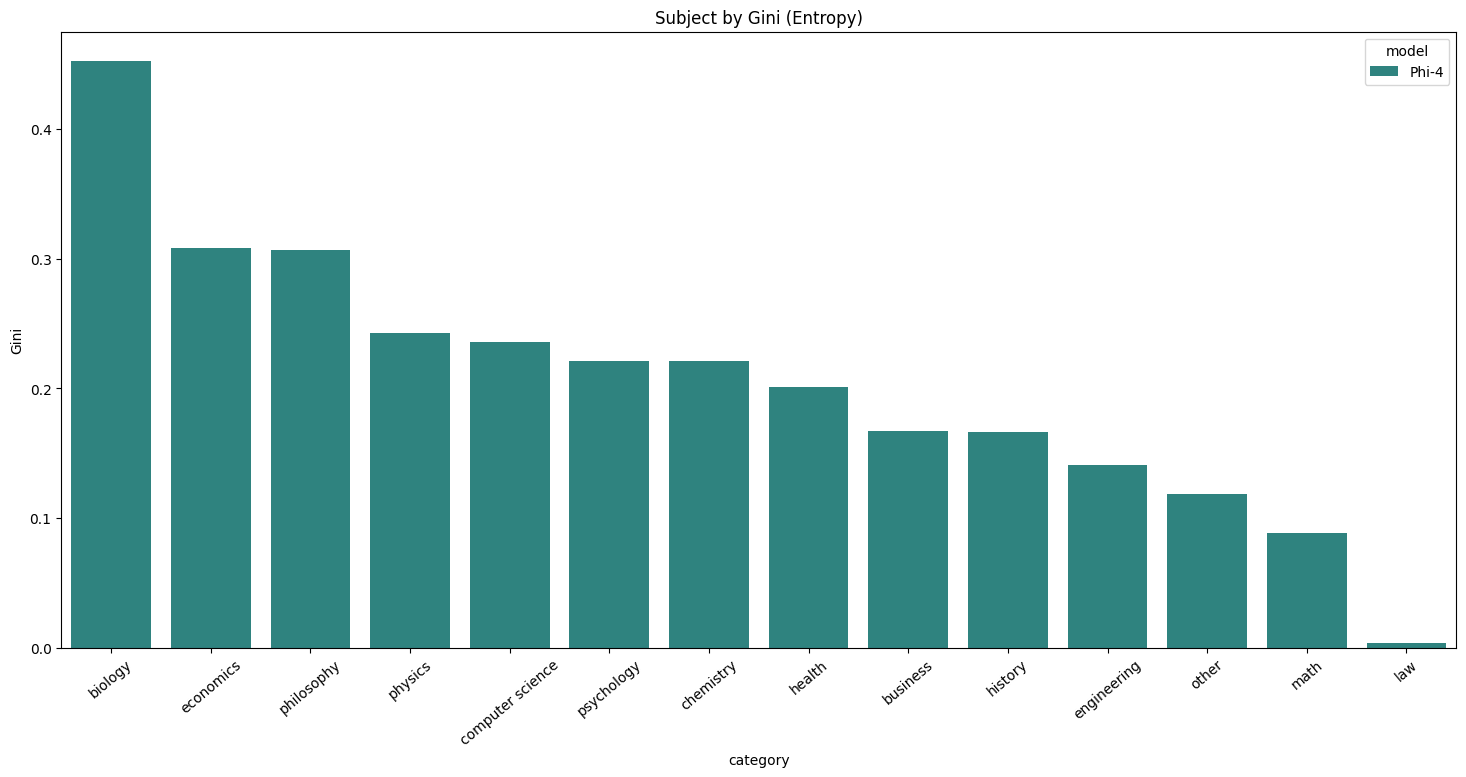

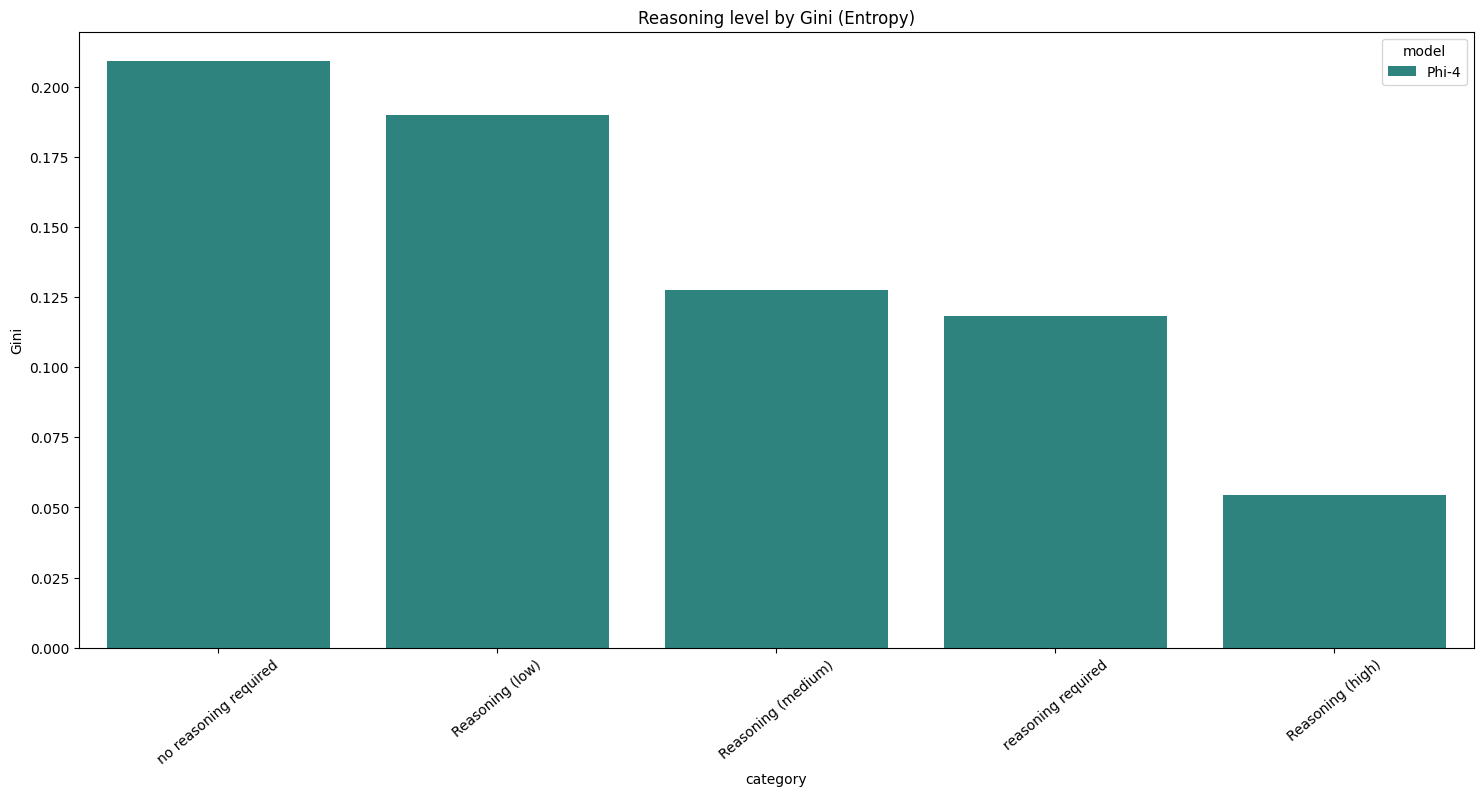

In [67]:
def plot_top_categories(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                ~df["category"].isin(
                    [
                        "ALL",
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(15)
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Subject by Gini ({title})")
    plt.ylabel("Gini")
    plt.xticks(rotation=40)
    plt.show()


def plot_reasoning(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                df["category"].isin(
                    [
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(15)
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Reasoning level by Gini ({title})")
    plt.ylabel("Gini")
    plt.xticks(rotation=40)
    plt.show()


plot_top_categories(final_results, "entropy_value_phi3", "Entropy")
plot_reasoning(final_results, "entropy_value_phi3", "Entropy")

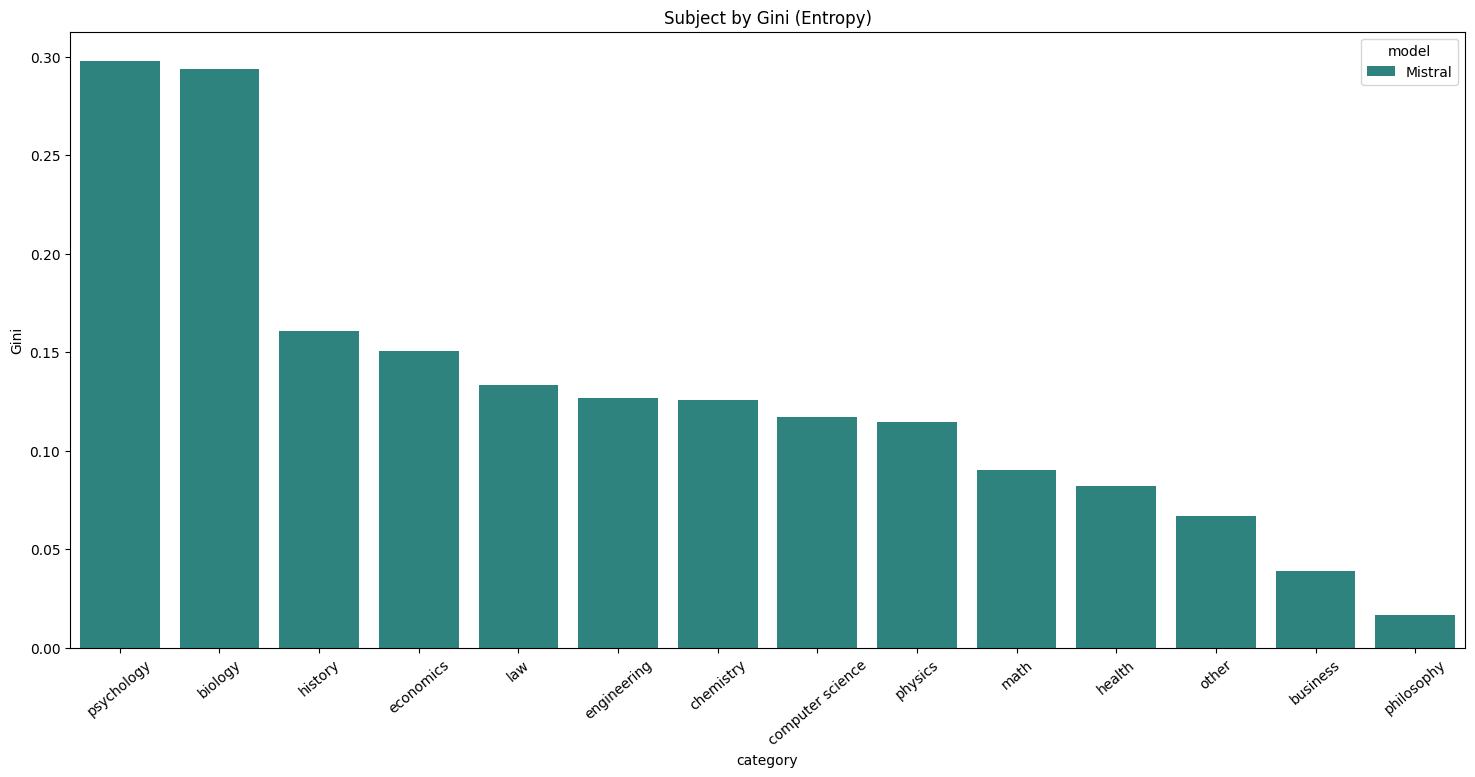

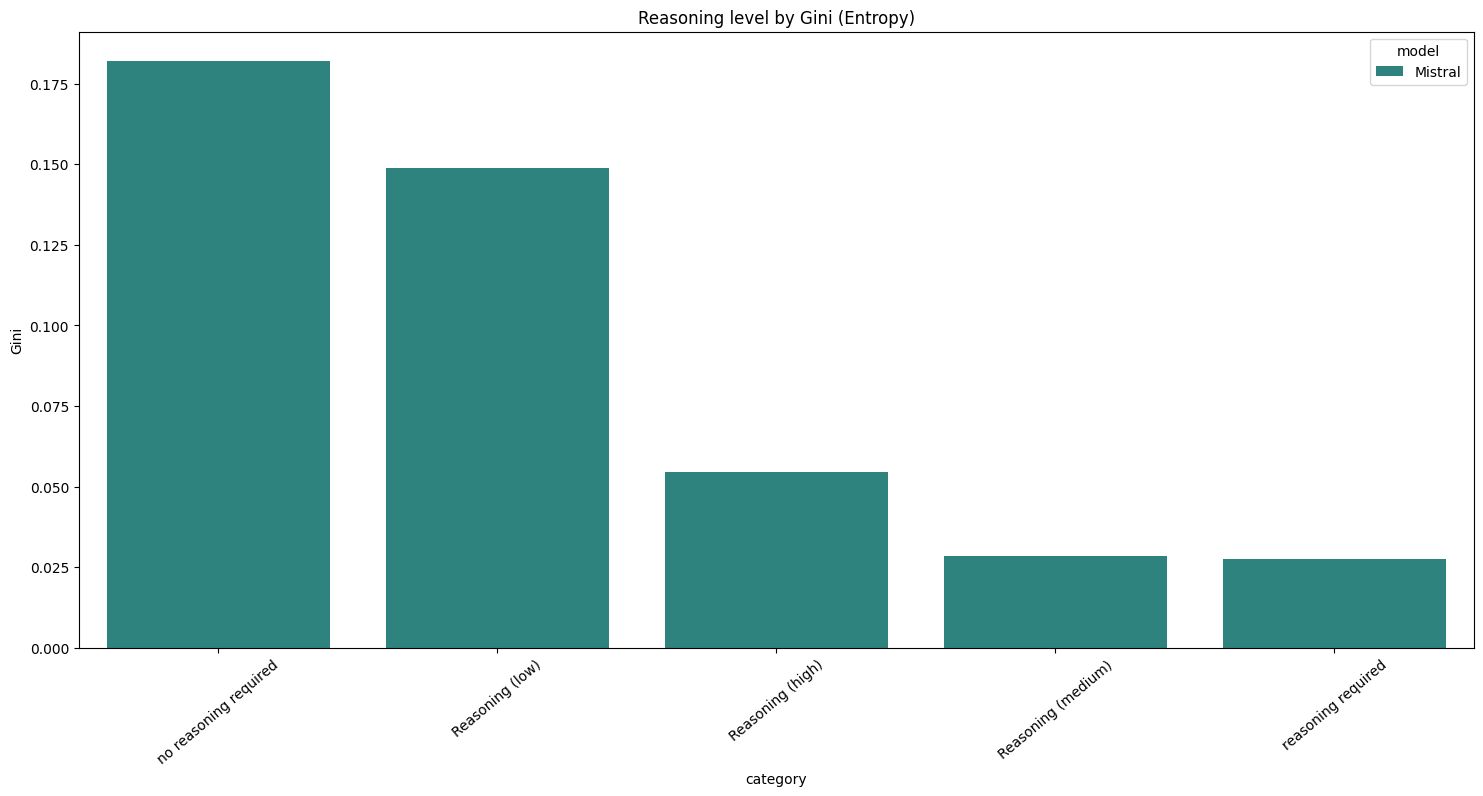

In [68]:
plot_top_categories(final_results, "entropy_value_mistral", "Entropy")
plot_reasoning(final_results, "entropy_value_mistral", "Entropy")

In [69]:
# Переделал функцию для категорий образования


def evaluate_question_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []

    # Для всех данных
    metrics = calculate_metrics(df[target_col], df[score_col])
    results.append(
        {
            "category": "ALL",
            "roc_auc": metrics["roc_auc"],
            "pr_auc": metrics["pr_auc"],
            "gini": metrics["gini"],
            "num_samples": len(df),
            "correct": df[target_col].sum(),
            "incorrect": len(df) - df[target_col].sum(),
            "model": model_name,
            "metric": score_col,
        }
    )

    # По категориям
    for category in df["masj_nominal_complexity"].unique():
        df_cat = df[df["masj_nominal_complexity"] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])

        results.append(
            {
                "category": category,
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    # По ризонингу (с уровнями сложности)
    for reasoning_steps in df["masj_num_reasoning_steps"].unique():
        df_cat = df[df["masj_num_reasoning_steps"] == reasoning_steps]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue

        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])

        results.append(
            {
                "category": f"Reasoning ({reasoning_steps})",
                "roc_auc": metrics["roc_auc"],
                "pr_auc": metrics["pr_auc"],
                "gini": metrics["gini"],
                "num_samples": len(df_cat),
                "correct": df_cat[target_col].sum(),
                "incorrect": len(df_cat) - df_cat[target_col].sum(),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)


evaluate_question_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3").sort_values(
    by="gini", ascending=False
)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
5,phd,0.166667,0.163973,0.666667,11,3,8,Phi-4,entropy_value_phi3
4,middle_school,0.350137,0.373572,0.299726,655,299,356,Phi-4,entropy_value_phi3
3,high_school,0.376977,0.457545,0.246046,2871,1493,1378,Phi-4,entropy_value_phi3
7,Reasoning (low),0.405050,0.583723,0.189899,2774,1788,986,Phi-4,entropy_value_phi3
0,ALL,0.417562,0.476963,0.164876,11393,6006,5387,Phi-4,entropy_value_phi3
2,undergraduate,0.425206,0.489760,0.149588,7229,3899,3330,Phi-4,entropy_value_phi3
6,Reasoning (medium),0.436211,0.461083,0.127578,7536,3766,3770,Phi-4,entropy_value_phi3
1,postgraduate,0.472670,0.469875,0.054660,627,312,315,Phi-4,entropy_value_phi3
8,Reasoning (high),0.472767,0.396036,0.054466,1078,450,628,Phi-4,entropy_value_phi3


In [70]:
category_phi = evaluate_question_model(mmlu_df, "Phi-4", "entropy_ans_correct_phi3", "entropy_value_phi3").sort_values(
    by="gini", ascending=False
)

In [71]:
# mmlu_df["masj_nominal_complexity"] = mmlu_df["question_id"].map(
#     mmlu_df.set_index("question_id")["masj_nominal_complexity"]
# )
mmlu_df["masj_nominal_complexity"].value_counts()

masj_nominal_complexity
undergraduate    7229
high_school      2871
middle_school     655
postgraduate      627
phd                11
Name: count, dtype: int64

In [72]:
evaluate_question_model(mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral").sort_values(
    by="gini", ascending=False
)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
7,Reasoning (low),0.574481,0.606210,0.148963,2774,1633,1141,Mistral,entropy_value_mistral
5,phd,0.541667,0.268849,0.083333,11,3,8,Mistral,entropy_value_mistral
1,postgraduate,0.540519,0.435458,0.081038,627,265,362,Mistral,entropy_value_mistral
3,high_school,0.532593,0.496492,0.065186,2871,1433,1438,Mistral,entropy_value_mistral
8,Reasoning (high),0.527270,0.392775,0.054540,1078,423,655,Mistral,entropy_value_mistral
0,ALL,0.520531,0.477666,0.041061,11393,5548,5845,Mistral,entropy_value_mistral
2,undergraduate,0.516912,0.480962,0.033823,7229,3560,3669,Mistral,entropy_value_mistral
6,Reasoning (medium),0.514199,0.451232,0.028399,7536,3492,4044,Mistral,entropy_value_mistral
4,middle_school,0.498182,0.411099,0.003636,655,287,368,Mistral,entropy_value_mistral


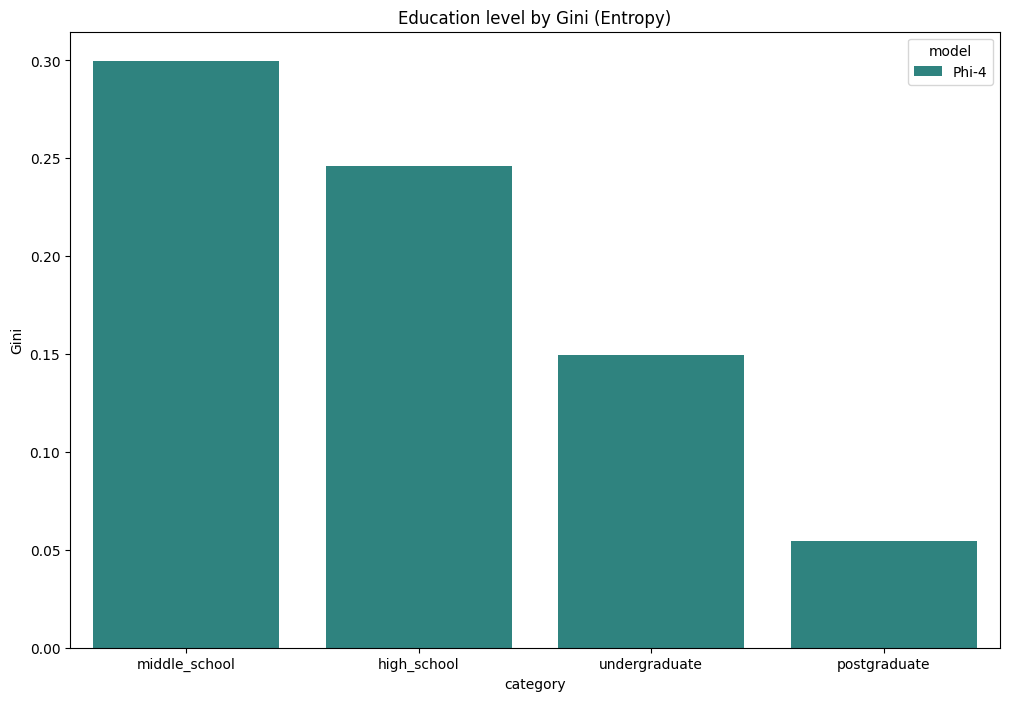

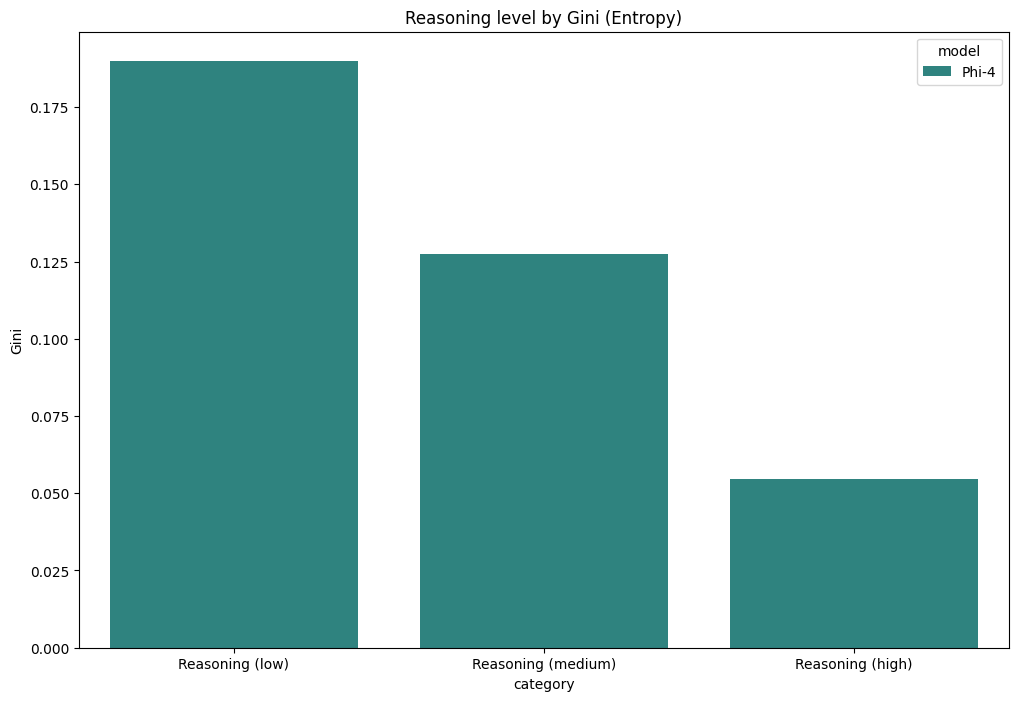

In [73]:
def plot_top_categories(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                ~df["category"].isin(
                    [
                        "phd",
                        "ALL",
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(20)
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Education level by Gini ({title})")
    plt.ylabel("Gini")
    plt.show()


def plot_reasoning(df, metric_col, title):
    top_categories = (
        df[
            (df["metric"] == metric_col)
            & (
                df["category"].isin(
                    [
                        "reasoning required",
                        "no reasoning required",
                        "Reasoning (low)",
                        "Reasoning (medium)",
                        "Reasoning (high)",
                    ]
                )
            )
        ]
        .sort_values(by="gini", ascending=False)
        .head(20)
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_categories, x="category", y="gini", hue="model", palette="viridis")
    plt.title(f"Reasoning level by Gini ({title})")
    plt.ylabel("Gini")
    plt.show()


plot_top_categories(category_phi, "entropy_value_phi3", "Entropy")
plot_reasoning(category_phi, "entropy_value_phi3", "Entropy")

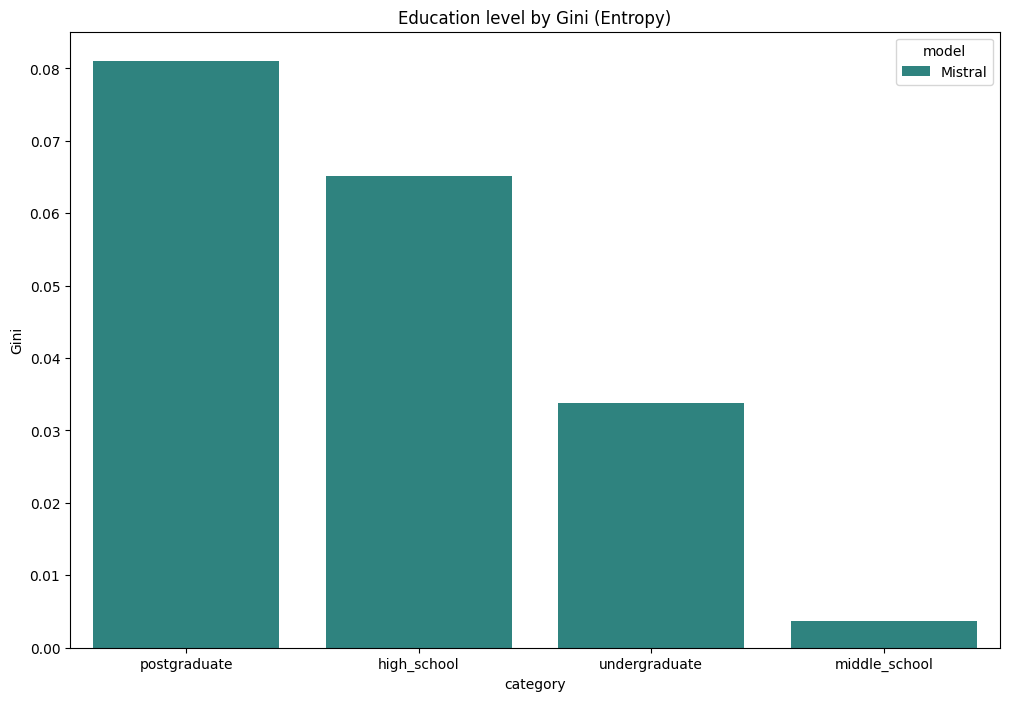

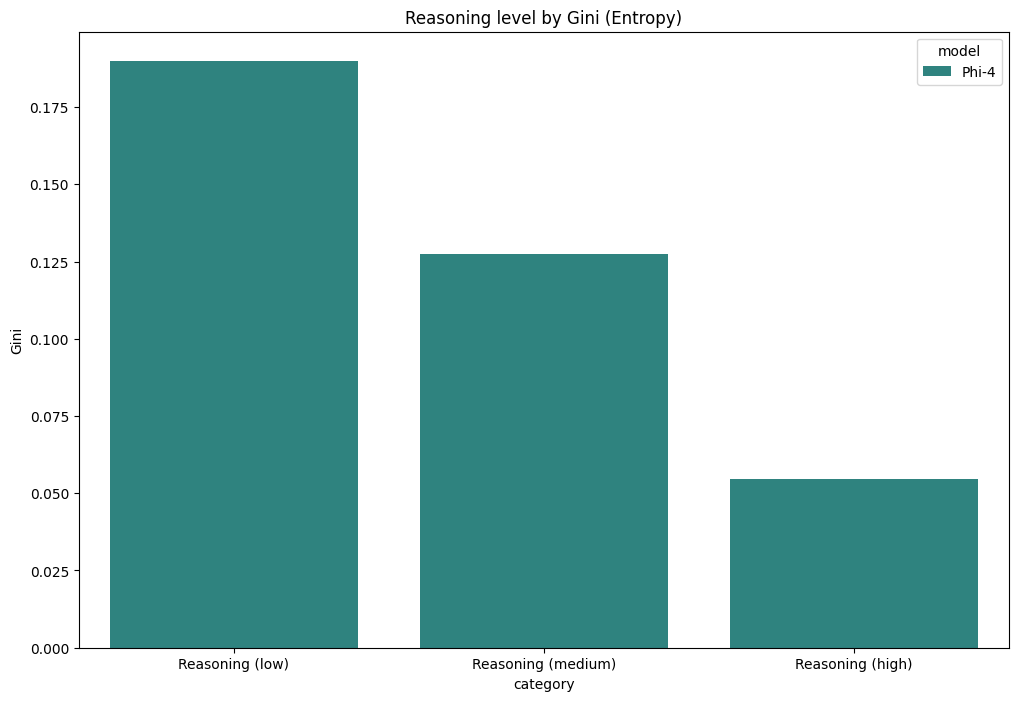

In [74]:
category_mistral = evaluate_question_model(
    mmlu_df, "Mistral", "entropy_ans_correct_mistral", "entropy_value_mistral"
).sort_values(by="gini", ascending=False)

plot_top_categories(category_mistral, "entropy_value_mistral", "Entropy")
plot_reasoning(category_phi, "entropy_value_phi3", "Entropy")